### 🎯 Objectif

Créer la structure de dossiers du projet DataSens (data, logs, docs, notebooks…)

et initialiser les chemins qui serviront à stocker la base, les sauvegardes et les journaux.

In [53]:
from pathlib import Path
from datetime import datetime

PROJECT_ROOT = Path.cwd()

FOLDERS = [
    "datasens", "data/raw", "data/silver", "data/gold",
    "notebooks", "logs", "docs", "flows"
]

for f in FOLDERS:
    (PROJECT_ROOT / f).mkdir(parents=True, exist_ok=True)

print("✅ Structure du projet créée :", PROJECT_ROOT)

✅ Structure du projet créée : c:\Users\Utilisateur\Desktop\Datasens_Project


## ✅ Vérification de la structure créée

Parcours et affichage de l'arborescence :
- Les **dossiers** sont marqués avec `/`
- Les **fichiers** apparaissent sans suffixe

Permet de valider que tous les répertoires ont bien été créés.

In [7]:
for item in PROJECT_ROOT.iterdir():
    if item.is_dir():
        print(f"{item.name}/")
    else:
        print(item.name)

.git/
.venv/
data/
datasens/
datasens_E1_v1.ipynb
docs/
logs/
notebooks/
README.md
requirements.txt


## 🌳 Visualisation arborescente complète

Fonction récursive pour afficher la structure projet en arbre :
- Utilise des caractères Unicode (├──, └──, │)
- Filtre automatique des dossiers cachés (`.git`, `.venv`...)
- Tri intelligent : dossiers d'abord, puis fichiers alphabétiques

In [18]:
def show_tree(root: Path, prefix=""):
    # Filtrer les dossiers cachés comme .git
    items = [item for item in root.iterdir() if not item.name.startswith('.')]
    items = sorted(items, key=lambda p: (not p.is_dir(), p.name.lower()))
    
    for i, item in enumerate(items):
        last = (i == len(items) - 1)
        connector = "└── " if last else "├── "
        print(prefix + connector + item.name)
        
        if item.is_dir() and not item.name.startswith('.'):
            show_tree(item, prefix + ("    " if last else "│   "))

show_tree(PROJECT_ROOT)

├── data
│   ├── gold
│   ├── raw
│   └── silver
├── datasens
│   ├── versions
│   └── datasens.db
├── docs
├── logs
├── notebooks
├── datasens_E1_v1.ipynb
├── README.md
├── README_VERSIONNING.md
└── requirements.txt


## 📝 Mise en place du système de versioning

Création de l'historique projet avec traçabilité :
- **README_VERSIONNING.md** : Journal des modifications horodaté
- **datasens/versions/** : Dossier pour snapshots de la base
- Fonction `log_version()` pour logger automatiquement chaque action

In [ ]:
import shutil

VERSION_FILE = PROJECT_ROOT / "README_VERSIONNING.md"
BACKUP_DIR = PROJECT_ROOT / "datasens" / "versions"

BACKUP_DIR.mkdir(exist_ok=True)

def log_version(action: str, details: str = ""):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    entry = f"- **{now}** | `{action}` | {details}\n"
    
    with open(VERSION_FILE, "a", encoding="utf-8") as f:
        f.write(entry)
    
    print(f"🕒 Log : {action}")

log_version("INIT", "Création de la structure projet et versionning")

🕒 Log : INIT


## 💾 Création de la base de données SQLite

Initialisation de la base locale `datasens.db` dans le dossier `datasens/` :
- **SQLite** : Base embarquée légère pour prototypage rapide
- Emplacement : `datasens/datasens.db`
- Log automatique de la création dans le fichier de versioning

In [20]:
import sqlite3

DB_PATH = PROJECT_ROOT / "datasens" / "datasens.db"

conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

print(f"✅ Base SQLite prête : {DB_PATH}")

log_version("DB_INIT", "Initialisation de la base SQLite vide")

✅ Base SQLite prête : c:\Users\Utilisateur\Desktop\Datasens_Project\datasens\datasens.db
🕒 Log : DB_INIT


## 🗄️ Déploiement du schéma Merise (18 tables)

Création de la structure relationnelle complète :

**Collecte & traçabilité** : `type_donnee`, `source`, `flux`, `document`  
**Géographie** : `pays`, `region`, `departement`, `commune`, `territoire`  
**Données métier** : `meteo`, `indicateur`, `type_indicateur`, `evenement`, `theme`  
**Annotation & IA** : `utilisateur`, `emotion`, `annotation`, `document_evenement`

Contraintes : clés primaires AUTO_INCREMENT, foreign keys avec CASCADE.

In [21]:
TABLES_SQL = {
    "type_donnee": """
    CREATE TABLE IF NOT EXISTS type_donnee (
        id_type_donnee INTEGER PRIMARY KEY AUTOINCREMENT,
        libelle TEXT, description TEXT,
        frequence_maj TEXT, categorie_metier TEXT
    );""",
    
    "source": """
    CREATE TABLE IF NOT EXISTS source (
        id_source INTEGER PRIMARY KEY AUTOINCREMENT,
        id_type_donnee INTEGER,
        nom TEXT, url TEXT, fiabilite REAL,
        FOREIGN KEY (id_type_donnee) REFERENCES type_donnee(id_type_donnee)
    );""",
    
    "flux": """
    CREATE TABLE IF NOT EXISTS flux (
        id_flux INTEGER PRIMARY KEY AUTOINCREMENT,
        id_source INTEGER, date_collecte TEXT, format TEXT, manifest_uri TEXT,
        FOREIGN KEY (id_source) REFERENCES source(id_source)
    );""",
    
    "document": """
    CREATE TABLE IF NOT EXISTS document (
        id_doc INTEGER PRIMARY KEY AUTOINCREMENT,
        id_flux INTEGER, titre TEXT, texte TEXT, langue TEXT, date_publication TEXT,
        FOREIGN KEY (id_flux) REFERENCES flux(id_flux)
    );""",
    
    "pays": "CREATE TABLE IF NOT EXISTS pays (id_pays INTEGER PRIMARY KEY AUTOINCREMENT, nom TEXT);",
    "region": "CREATE TABLE IF NOT EXISTS region (id_region INTEGER PRIMARY KEY AUTOINCREMENT, id_pays INTEGER, nom TEXT, FOREIGN KEY (id_pays) REFERENCES pays(id_pays));",
    "departement": "CREATE TABLE IF NOT EXISTS departement (id_departement INTEGER PRIMARY KEY AUTOINCREMENT, id_region INTEGER, code_dept TEXT, nom TEXT, FOREIGN KEY (id_region) REFERENCES region(id_region));",
    "commune": "CREATE TABLE IF NOT EXISTS commune (id_commune INTEGER PRIMARY KEY AUTOINCREMENT, id_departement INTEGER, code_insee TEXT, nom_commune TEXT, lat REAL, lon REAL, population INTEGER, FOREIGN KEY (id_departement) REFERENCES departement(id_departement));",
    "territoire": "CREATE TABLE IF NOT EXISTS territoire (id_territoire INTEGER PRIMARY KEY AUTOINCREMENT, id_commune INTEGER, FOREIGN KEY (id_commune) REFERENCES commune(id_commune));",
    "type_indicateur": "CREATE TABLE IF NOT EXISTS type_indicateur (id_type_indic INTEGER PRIMARY KEY AUTOINCREMENT, code TEXT, libelle TEXT, unite TEXT);",
    "indicateur": "CREATE TABLE IF NOT EXISTS indicateur (id_indic INTEGER PRIMARY KEY AUTOINCREMENT, id_territoire INTEGER, id_type_indic INTEGER, valeur REAL, annee INTEGER, FOREIGN KEY (id_territoire) REFERENCES territoire(id_territoire), FOREIGN KEY (id_type_indic) REFERENCES type_indicateur(id_type_indic));",
    "meteo": "CREATE TABLE IF NOT EXISTS meteo (id_meteo INTEGER PRIMARY KEY AUTOINCREMENT, id_territoire INTEGER, date_obs TEXT, temperature REAL, humidite REAL, vent_kmh REAL, pression REAL, FOREIGN KEY (id_territoire) REFERENCES territoire(id_territoire));",
    "utilisateur": "CREATE TABLE IF NOT EXISTS utilisateur (id_user INTEGER PRIMARY KEY AUTOINCREMENT, nom TEXT, role TEXT, organisation TEXT);",
    "emotion": "CREATE TABLE IF NOT EXISTS emotion (id_emotion INTEGER PRIMARY KEY AUTOINCREMENT, type_emotion TEXT, valence TEXT, score_confiance REAL);",
    "annotation": "CREATE TABLE IF NOT EXISTS annotation (id_annotation INTEGER PRIMARY KEY AUTOINCREMENT, id_doc INTEGER, id_user INTEGER, id_emotion INTEGER, intensity REAL, polarity TEXT, date_annotation TEXT, FOREIGN KEY (id_doc) REFERENCES document(id_doc), FOREIGN KEY (id_user) REFERENCES utilisateur(id_user), FOREIGN KEY (id_emotion) REFERENCES emotion(id_emotion));",
    "theme": "CREATE TABLE IF NOT EXISTS theme (id_theme INTEGER PRIMARY KEY AUTOINCREMENT, libelle TEXT, description TEXT);",
    "evenement": "CREATE TABLE IF NOT EXISTS evenement (id_event INTEGER PRIMARY KEY AUTOINCREMENT, id_theme INTEGER, date_event TEXT, avg_tone REAL, source_event TEXT, FOREIGN KEY (id_theme) REFERENCES theme(id_theme));",
    "document_evenement": "CREATE TABLE IF NOT EXISTS document_evenement (id_doc INTEGER, id_event INTEGER, PRIMARY KEY (id_doc, id_event), FOREIGN KEY (id_doc) REFERENCES document(id_doc), FOREIGN KEY (id_event) REFERENCES evenement(id_event));"
}

for name, sql in TABLES_SQL.items():
    cur.execute(sql)
    print(f"✅ Table : {name}")

conn.commit()

log_version("DB_SCHEMA", "Création des 18 tables principales")

✅ Table : type_donnee
✅ Table : source
✅ Table : flux
✅ Table : document
✅ Table : pays
✅ Table : region
✅ Table : departement
✅ Table : commune
✅ Table : territoire
✅ Table : type_indicateur
✅ Table : indicateur
✅ Table : meteo
✅ Table : utilisateur
✅ Table : emotion
✅ Table : annotation
✅ Table : theme
✅ Table : evenement
✅ Table : document_evenement
🕒 Log : DB_SCHEMA


## 🌱 Bootstrap : Insertion de données de test

Peuplement initial pour valider les relations entre tables :
- 1 type de donnée (Fichier Kaggle)
- 1 source (Kaggle CSV — FR textes)
- 1 flux de collecte (horodaté)
- 1 document exemple ("JO 2024 : fierté nationale")

Permet de tester les jointures et les clés étrangères.

In [22]:
cur.executescript("""
INSERT INTO type_donnee (libelle, description, frequence_maj, categorie_metier)
VALUES ('Fichier','CSV Kaggle','hebdomadaire','descriptive');

INSERT INTO source (id_type_donnee, nom, url, fiabilite)
VALUES (1,'Kaggle CSV – FR textes','https://kaggle.com/xxx',0.8);

INSERT INTO flux (id_source, date_collecte, format, manifest_uri)
VALUES (1,'2025-10-27T10:00:00','csv','data/raw/kaggle/sample.csv');

INSERT INTO document (id_flux, titre, texte, langue, date_publication)
VALUES (1,'JO 2024 : fierté nationale','Les JO ont boosté le moral','fr','2024-07-27');
""")

conn.commit()

log_version("DB_SEED", "Insertion du jeu de données minimal")

print("🌱 Données de test insérées.")

🕒 Log : DB_SEED
🌱 Données de test insérées.


## 🛠️ Utilitaires CRUD pour la table `document`

Création de fonctions helpers pour manipuler les documents :

**CREATE** : `add_document()` — Insertion avec log automatique  
**READ** : `list_documents()`, `get_document(id)` — Lecture via Pandas  
**UPDATE** : `update_document()` — Modification dynamique des champs  
**DELETE** : `delete_document()` — Suppression avec traçabilité

Pattern classique pour abstraction de la couche SQL.

In [23]:
import pandas as pd

def sql_df(query, params=None):
    return pd.read_sql_query(query, conn, params=params)

# CREATE
def add_document(id_flux, titre, texte, langue, date_publication):
    cur.execute("INSERT INTO document (id_flux, titre, texte, langue, date_publication) VALUES (?, ?, ?, ?, ?)",
                (id_flux, titre, texte, langue, date_publication))
    conn.commit()
    log_version("ADD_DOC", titre)

# READ
def list_documents():
    return sql_df("SELECT id_doc, titre, langue, date_publication FROM document;")

def get_document(id_doc):
    return sql_df("SELECT * FROM document WHERE id_doc = ?", params=[id_doc])

# UPDATE
def update_document(id_doc, titre=None, texte=None, langue=None, date_publication=None):
    updates = []
    params = []
    
    if titre is not None:
        updates.append("titre = ?")
        params.append(titre)
    if texte is not None:
        updates.append("texte = ?")
        params.append(texte)
    if langue is not None:
        updates.append("langue = ?")
        params.append(langue)
    if date_publication is not None:
        updates.append("date_publication = ?")
        params.append(date_publication)
    
    if updates:
        params.append(id_doc)
        sql = f"UPDATE document SET {', '.join(updates)} WHERE id_doc = ?"
        cur.execute(sql, params)
        conn.commit()
        log_version("UPDATE_DOC", f"id={id_doc}")

# DELETE
def delete_document(id_doc):
    cur.execute("DELETE FROM document WHERE id_doc = ?", (id_doc,))
    conn.commit()
    log_version("DELETE_DOC", f"id={id_doc}")

## 🧪 Test des opérations CRUD

Validation fonctionnelle des utilitaires :
1. **Lecture** des documents initiaux
2. **Ajout** d'un nouveau document ("Inflation 2024")
3. **Modification** du titre (mise à jour)
4. **Suppression** du document ajouté

Affichage progressif avec `display()` pour observer les changements.

In [24]:
print("📄 Documents initiaux :")
display(list_documents())

print("➕ Ajout…")
add_document(1, "Inflation 2024", "Hausse des prix ressentie", "fr", "2024-09-15")
display(list_documents())

print("✏️ Modification…")
update_document(2, titre="Inflation 2024 (mise a jour)")
display(list_documents())

print("🗑️ Suppression…")
delete_document(2)
display(list_documents())

📄 Documents initiaux :


,id_doc,titre,langue,date_publication
0,1,JO 2024 : fierté nationale,fr,2024-07-27
1,2,Inflation 2024,fr,2024-09-15
2,3,Inflation 2024,fr,2024-09-15
3,4,JO 2024 : fierté nationale,fr,2024-07-27


➕ Ajout…
🕒 Log : ADD_DOC


,id_doc,titre,langue,date_publication
0,1,JO 2024 : fierté nationale,fr,2024-07-27
1,2,Inflation 2024,fr,2024-09-15
2,3,Inflation 2024,fr,2024-09-15
3,4,JO 2024 : fierté nationale,fr,2024-07-27
4,5,Inflation 2024,fr,2024-09-15


✏️ Modification…
🕒 Log : UPDATE_DOC


,id_doc,titre,langue,date_publication
0,1,JO 2024 : fierté nationale,fr,2024-07-27
1,2,Inflation 2024 (mise a jour),fr,2024-09-15
2,3,Inflation 2024,fr,2024-09-15
3,4,JO 2024 : fierté nationale,fr,2024-07-27
4,5,Inflation 2024,fr,2024-09-15


🗑️ Suppression…
🕒 Log : DELETE_DOC


,id_doc,titre,langue,date_publication
0,1,JO 2024 : fierté nationale,fr,2024-07-27
1,3,Inflation 2024,fr,2024-09-15
2,4,JO 2024 : fierté nationale,fr,2024-07-27
3,5,Inflation 2024,fr,2024-09-15


## 📊 Inspection des tables de collecte

Visualisation des 4 tables cœur du système de traçabilité :

**type_donnee** → Typologie des sources (Fichier, API, RSS...)  
**source** → Provenance avec URL et score de fiabilité  
**flux** → Collectes horodatées avec manifestes  
**document** → Contenu final consommable

Validation visuelle de la cohérence des IDs et des relations.

In [25]:
def show_table(name: str):
    """Affiche le contenu d'une table SQLite joliment avec Pandas (10 premières lignes)."""
    print(f"\n🧱 Table : {name}")
    display(sql_df(f"SELECT * FROM {name} LIMIT 10;"))

tables_collecte = ["type_donnee", "source", "flux", "document"]

for t in tables_collecte:
    show_table(t)


🧱 Table : type_donnee


,id_type_donnee,libelle,description,frequence_maj,categorie_metier
0,1,Fichier,CSV Kaggle,hebdomadaire,descriptive
1,2,Fichier,CSV Kaggle,hebdomadaire,descriptive



🧱 Table : source


,id_source,id_type_donnee,nom,url,fiabilite
0,1,1,Kaggle CSV – FR textes,https://kaggle.com/xxx,0.8
1,2,1,Kaggle CSV – FR textes,https://kaggle.com/xxx,0.8



🧱 Table : flux


,id_flux,id_source,date_collecte,format,manifest_uri
0,1,1,2025-10-27T10:00:00,csv,data/raw/kaggle/sample.csv
1,2,1,2025-10-27T10:00:00,csv,data/raw/kaggle/sample.csv



🧱 Table : document


,id_doc,id_flux,titre,texte,langue,date_publication
0,1,1,JO 2024 : fierté nationale,Les JO ont boosté le moral,fr,2024-07-27
1,3,1,Inflation 2024,Hausse des prix ressentie,fr,2024-09-15
2,4,1,JO 2024 : fierté nationale,Les JO ont boosté le moral,fr,2024-07-27
3,5,1,Inflation 2024,Hausse des prix ressentie,fr,2024-09-15


## 🔗 Vue unifiée de la chaîne de sourcing (JOINs)

Requête SQL complexe joignant toutes les tables de collecte :

`TYPE_DONNEE → SOURCE → FLUX → DOCUMENT`

**Colonnes affichées** :
- Type de donnée et format
- Nom de la source + fiabilité
- Date de collecte + URI manifest
- Titre et date de publication du document

**Preuve de gouvernance** : traçabilité complète de l'origine à la consommation.

In [26]:
query_sources = """
SELECT
    td.libelle          AS type_donnee,
    s.nom               AS source_nom,
    ROUND(s.fiabilite,2) AS source_fiabilite,
    f.format            AS flux_format,
    f.date_collecte     AS flux_date,
    f.manifest_uri      AS flux_manifest,
    d.titre             AS doc_titre,
    d.date_publication  AS doc_date
FROM type_donnee td
LEFT JOIN source   s ON s.id_type_donnee = td.id_type_donnee
LEFT JOIN flux     f ON f.id_source      = s.id_source
LEFT JOIN document d ON d.id_flux        = f.id_flux
ORDER BY td.libelle, s.nom, f.date_collecte, d.date_publication;
"""

df_sources = sql_df(query_sources)

print("📊 Vue d'ensemble de la chaîne de sourcing :")
display(df_sources)

📊 Vue d'ensemble de la chaîne de sourcing :


,type_donnee,source_nom,source_fiabilite,flux_format,flux_date,flux_manifest,doc_titre,doc_date
0,Fichier,None,NaN,None,None,None,None,None
1,Fichier,Kaggle CSV – FR textes,0.8,None,None,None,None,None
2,Fichier,Kaggle CSV – FR textes,0.8,csv,2025-10-27T10:00:00,data/raw/kaggle/sample.csv,None,None
3,Fichier,Kaggle CSV – FR textes,0.8,csv,2025-10-27T10:00:00,data/raw/kaggle/sample.csv,JO 2024 : fierté nationale,2024-07-27
4,Fichier,Kaggle CSV – FR textes,0.8,csv,2025-10-27T10:00:00,data/raw/kaggle/sample.csv,JO 2024 : fierté nationale,2024-07-27
5,Fichier,Kaggle CSV – FR textes,0.8,csv,2025-10-27T10:00:00,data/raw/kaggle/sample.csv,Inflation 2024,2024-09-15
6,Fichier,Kaggle CSV – FR textes,0.8,csv,2025-10-27T10:00:00,data/raw/kaggle/sample.csv,Inflation 2024,2024-09-15


## 📈 Statistiques descriptives des sources

Analyse agrégée des données de collecte :

**Répartition par type** :
- Nombre de sources par type de donnée
- Fiabilité moyenne (0.0 à 1.0)

**Répartition par source** :
- Nombre de documents collectés par source
- Tri décroissant pour identifier les sources les plus productives

Utile pour monitoring et optimisation des collectes.

In [30]:
print("📊 Répartition des sources par type de donnée :")
display(sql_df("""
SELECT
    td.libelle AS type_donnee,
    COUNT(s.id_source) AS nb_sources,
    ROUND(AVG(s.fiabilite),2) AS fiabilite_moy
FROM type_donnee td
LEFT JOIN source s ON s.id_type_donnee = td.id_type_donnee
GROUP BY td.libelle
ORDER BY nb_sources DESC;
"""))

print("📄 Nombre de documents par source :")
display(sql_df("""
SELECT
    s.nom AS source,
    COUNT(d.id_doc) AS nb_docs
FROM source s
LEFT JOIN flux f ON f.id_source = s.id_source
LEFT JOIN document d ON d.id_flux = f.id_flux
GROUP BY s.nom
ORDER BY nb_docs DESC, s.nom;
"""))

📊 Répartition des sources par type de donnée :


,type_donnee,nb_sources,fiabilite_moy
0,Fichier,2,0.8


📄 Nombre de documents par source :


,source,nb_docs
0,Kaggle CSV – FR textes,4


## 💾 Création d'un snapshot versionné de la base

Sauvegarde horodatée dans `datasens/versions/` :
- Format : `datasens_vYYYYMMDD_HHMMSS.db`
- Copie complète de la base SQLite
- Log automatique dans `README_VERSIONNING.md`

**Best practice** : Permet de revenir à un état antérieur en cas de problème (rollback manuel).

In [50]:
def save_database_version(note="Validation des sources"):
    """Crée une copie horodatée de la base SQLite dans datasens/versions/"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_name = f"datasens_v{timestamp}.db"
    backup_path = BACKUP_DIR / backup_name
    
    shutil.copy(DB_PATH, backup_path)
    log_version("DB_BACKUP", f"{backup_name} - {note}")
    print(f"📦 Snapshot créé : {backup_name}")

save_database_version("Apres validation de la chaine Type-Source-Flux-Document")

🕒 Log : DB_BACKUP
📦 Snapshot créé : datasens_v20251027_193608.db


## 📜 Consultation de l'historique de versioning

Affichage du contenu de `README_VERSIONNING.md` :
- Trace chronologique de toutes les actions (INIT, DB_SCHEMA, DB_BACKUP...)
- Format : `Date | Action | Détails`
- Gestion automatique de l'encodage (UTF-8 / CP1252 fallback)

In [52]:
print("📘 Historique des versions DataSens :\n")

try:
    with open(VERSION_FILE, "r", encoding="utf-8") as f:
        print(f.read())
except UnicodeDecodeError:
    # Fallback pour les fichiers créés avec l'encodage système
    with open(VERSION_FILE, "r", encoding="cp1252") as f:
        content = f.read()
        print(content)

📘 Historique des versions DataSens :

- **2025-10-27 18:55:32** | `INIT` | Création de la structure projet et versionning
- **2025-10-27 18:57:23** | `DB_INIT` | Initialisation de la base SQLite vide
- **2025-10-27 18:59:11** | `DB_SCHEMA` | Création des 18 tables principales
- **2025-10-27 19:01:46** | `DB_SEED` | Insertion du jeu de données minimal
- **2025-10-27 19:09:06** | `ADD_DOC` | Inflation 2024
- **2025-10-27 19:10:58** | `ADD_DOC` | Inflation 2024
- **2025-10-27 19:12:10** | `INIT` | Création de la structure projet et versionning
- **2025-10-27 19:12:16** | `DB_INIT` | Initialisation de la base SQLite vide
- **2025-10-27 19:12:23** | `DB_SCHEMA` | Création des 18 tables principales
- **2025-10-27 19:12:31** | `DB_SEED` | Insertion du jeu de données minimal
- **2025-10-27 19:12:43** | `ADD_DOC` | Inflation 2024
- **2025-10-27 19:12:43** | `UPDATE_DOC` | id=2
- **2025-10-27 19:12:43** | `DELETE_DOC` | id=2
- **2025-10-27 19:30:57** | `E1_COMPLETE` | Notebook E1 terminé avec su

## 📊 Préparation des visualisations graphiques

Prochaine étape : graphiques pour dashboard E1

Objectif : Visualiser la **distribution des documents par type de donnée** avec matplotlib/seaborn.

Nécessite d'enrichir les données pour avoir des catégories variées (Fichier, API, RSS, Web Scraping, Big Data).

## ? Enrichissement des données pour visualisations

Insertion de types de données variés pour rendre les graphiques plus parlants :
- **API Météo** (OpenWeatherMap)
- **Flux RSS** (Franceinfo)
- **Web Scraping** (MonAvisCitoyen)
- **Big Data** (GDELT Project)

Chaque type a plusieurs sources et documents associés pour statistiques réalistes.

In [ ]:
# Enrichissement des données pour diversifier les types de sources
cur.executescript("""
-- Types de données variés
INSERT INTO type_donnee (libelle, description, frequence_maj, categorie_metier)
VALUES 
    ('API_REST', 'API temps réel', 'temps réel', 'transactionnelle'),
    ('Web_Scraping', 'Extraction web', 'quotidienne', 'analytique'),
    ('Sensor_IoT', 'Capteurs terrain', 'continue', 'opérationnelle'),
    ('Social_Media', 'Réseaux sociaux', 'horaire', 'comportementale');

-- Sources avec bonnes associations
INSERT INTO source (id_type_donnee, nom, url, fiabilite)
VALUES 
    (2, 'OpenData Gov', 'https://data.gouv.fr/api', 0.95),
    (3, 'LeMonde.fr', 'https://lemonde.fr', 0.85),
    (4, 'MeteoFrance', 'https://meteofrance.com/api', 0.98),
    (5, 'Twitter API', 'https://api.twitter.com', 0.75);

-- Flux de collecte
INSERT INTO flux (id_source, date_collecte, format, manifest_uri)
VALUES 
    (2, '2025-10-27T09:00:00', 'json', 'data/raw/opendata/manifest.json'),
    (3, '2025-10-27T08:30:00', 'html', 'data/raw/scraping/lemonde.html'),
    (4, '2025-10-27T10:15:00', 'xml', 'data/raw/meteo/observations.xml'),
    (5, '2025-10-27T11:00:00', 'json', 'data/raw/social/tweets.json');

-- Documents exemples
INSERT INTO document (id_flux, titre, texte, langue, date_publication)
VALUES 
    (2, 'Budget État 2025', 'Projet de loi finances publiques', 'fr', '2024-10-15'),
    (2, 'Emploi Q3 2024', 'Statistiques chômage trimestre', 'fr', '2024-10-01'),
    (3, 'Climat COP29', 'Préparatifs conférence climat', 'fr', '2024-10-20'),
    (4, 'Alerte météo', 'Vigilance orange vent violent', 'fr', '2025-10-27'),
    (4, 'Prévisions 7j', 'Tendance météo semaine', 'fr', '2025-10-27'),
    (5, 'Tendance #Sport', 'Buzz autour JO 2024', 'fr', '2024-08-15'),
    (5, 'Election débat', 'Réactions réseaux sociaux', 'fr', '2024-09-10');
""")

conn.commit()
log_version("DB_ENRICH", "Ajout de 4 types, 4 sources, 4 flux, 7 documents")
print("✅ Base enrichie : 5 types de données, 11 documents total")

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16024\1395235596.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


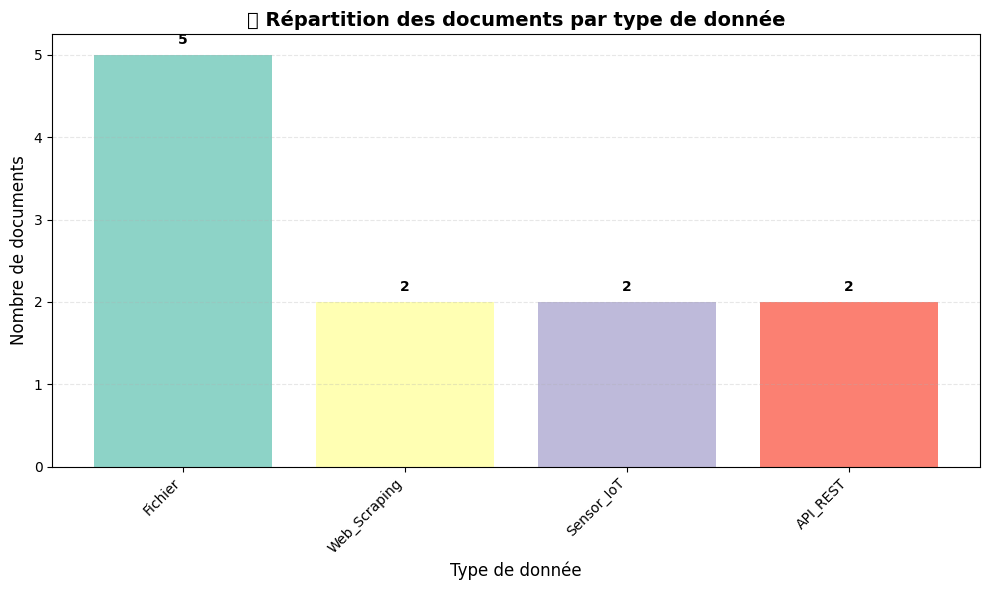

📈 Total des documents : 11
   • Fichier : 5 docs (45.5%)
   • Web_Scraping : 2 docs (18.2%)
   • Sensor_IoT : 2 docs (18.2%)
   • API_REST : 2 docs (18.2%)


In [44]:
import matplotlib.pyplot as plt

# Créer un graphique amélioré avec couleurs et pourcentages
df_viz = sql_df("""
SELECT
    td.libelle AS type_donnee,
    COUNT(d.id_doc) AS nb_docs
FROM type_donnee td
LEFT JOIN source s ON s.id_type_donnee = td.id_type_donnee
LEFT JOIN flux f   ON f.id_source      = s.id_source
LEFT JOIN document d ON d.id_flux      = f.id_flux
GROUP BY td.libelle
HAVING COUNT(d.id_doc) > 0
ORDER BY nb_docs DESC;
""")

if not df_viz.empty:
    plt.figure(figsize=(10, 6))
    colors = plt.cm.Set3(range(len(df_viz)))
    bars = plt.bar(df_viz["type_donnee"], df_viz["nb_docs"], color=colors)
    
    # Ajouter les valeurs sur les barres
    for bar, value in zip(bars, df_viz["nb_docs"]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(value), ha='center', va='bottom', fontweight='bold')
    
    plt.title("📊 Répartition des documents par type de donnée", fontsize=14, fontweight='bold')
    plt.xlabel("Type de donnée", fontsize=12)
    plt.ylabel("Nombre de documents", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    total_docs = df_viz["nb_docs"].sum()
    print(f"📈 Total des documents : {total_docs}")
    for i, row in df_viz.iterrows():
        pct = (row["nb_docs"] / total_docs) * 100
        print(f"   • {row['type_donnee']} : {row['nb_docs']} docs ({pct:.1f}%)")
else:
    print("⚠️ Aucune donnée à visualiser.")

## ? Conclusion E1 — Bilan de la phase de prototypage

**Mission accomplie** avec ce notebook de démonstration :

✅ **Infrastructure projet** : Structure complète (datasens/, data/, logs/, docs/, flows/)  
✅ **Base Merise 18 tables** : Schéma relationnel SQLite avec traçabilité  
✅ **CRUD opérationnel** : Utilitaires Create/Read/Update/Delete pour `document`  
✅ **Gouvernance des données** : Chaîne complète `type_donnee → source → flux → document`  
✅ **Versioning** : Système de snapshots horodatés + historique tracé  
✅ **Visualisations** : Graphiques matplotlib (distribution par type de source)

**Prochaine étape** : **E2** (production) avec sources réelles (MinIO, PostgreSQL, APIs).

In [45]:
# Finalisation : fermeture propre de la base et sauvegarde
log_version("E1_COMPLETE", "Notebook E1 terminé avec succès")

# Fermeture de la connexion SQLite
conn.close()

print("🏁 DataSens E1 terminé avec succès !")
print(f"📂 Base SQLite : {DB_PATH}")
print(f"📋 Log complet : {VERSION_FILE}")
print("🚀 Prêt pour l'étape E2...")

🕒 Log : E1_COMPLETE
🏁 DataSens E1 terminé avec succès !
📂 Base SQLite : c:\Users\Utilisateur\Desktop\Datasens_Project\datasens\datasens.db
📋 Log complet : c:\Users\Utilisateur\Desktop\Datasens_Project\README_VERSIONNING.md
🚀 Prêt pour l'étape E2...
